In [1]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import json
import re

from utils import test_model, compare_models_prediction, generate_z_samples
from zoo_utils import load_hyperrep_edx

from shrp.models.def_net import CNN, CNN3
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

## Loading data

In [4]:
DATASETS = ['svhn', 'cifar10', 'eurosat']
DATASET_LABELS = {
    'svhn': 'SVHN',
    'cifar10': 'CIFAR-10',
    'eurosat': 'EuroSAT'
}

DS_ORDER = ['SVHN', 'CIFAR-10', 'EuroSAT']
HR_ORDER = ['Contrastive + Structure (Baseline)', 'Behavior', 'Contrastive + Behavior', 'Structure + Behavior', 'Contrastive + Structure + Behavior']
HR_PLOT = ['Contrastive + Structure (Baseline)', 'Contrastive + Behavior', 'Contrastive + Structure + Behavior']

EXPERIMENT_PATH = Path.cwd() / 'results' 

In [5]:
# Model zoo train set
TRAINSET_DS = {ds: torch.load(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/{ds}_train_zoo_relu/dataset.pt')['trainset'] for ds in DATASETS}
TRAINSET_DL = {ds: torch.utils.data.DataLoader(TRAINSET_DS[ds], batch_size=64, shuffle=True) for ds in DATASETS}

# Test set corresponding to the data used to train the model zoo
TESTSET_DS = {ds: torch.load(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/{ds}_train_zoo_relu/dataset.pt')['testset'] for ds in DATASETS}
TESTSET_DL = {ds: torch.utils.data.DataLoader(TESTSET_DS[ds], batch_size=64, shuffle=False) for ds in DATASETS}

# Model zoo
ZOO_PATH = {ds: Path(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/zoos/{ds}_train_zoo_relu') for ds in DATASETS}
ZOO_DS = {ds: torch.load(ZOO_PATH[ds] / 'dataset_test.pt') for ds in DATASETS}
ZOO_DL = {ds: torch.utils.data.DataLoader(ZOO_DS[ds], batch_size=16, shuffle=False) for ds in DATASETS}

# Threshold used to define models that "perform well"; depends on the zoo
MODEL_ACC_THR = {
    'svhn': 0.8,
    'cifar10': 0.6,
    'eurosat': 0.7
}

# Path to the hyper-representation models
HYPERREP_PATH = {ds: Path(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/hyperrepresentations/tune/{ds}_train_hyperrep') for ds in DATASETS}

In [6]:
X_DIM_1, X_DIM_2 = next(iter(ZOO_DL['svhn']))[0].shape[1:3]
X_COLS = [f'Dimension {i}' for i in range(X_DIM_1 * X_DIM_2)]

Z_DIM_1 = X_DIM_1
Z_DIM_2 = 64
Z_COLS = [f'Dimension {i}' for i in range(Z_DIM_1 * Z_DIM_2)]

In [7]:
MAX_EPOCH = 100

df_hr = pd.DataFrame(columns=[
    'Model zoo',
    'Trial ID',
    'Learning rate',
    'Latent dimension',
    'Behaviour loss',
    'Query set',
    'Query dataset',
    '# of queries',
    'Gamma',
    'Beta',
    'Epoch',
    'Train loss',
    'Train loss (contrast)', 
    'Train loss (recon)',
    'Train loss (structure)', 
    'Train loss (behaviour)',
    'Test loss',
    'Test loss (contrast)', 
    'Test loss (recon)',
    'Test loss (structure)', 
    'Test loss (behaviour)',
    'Dstk: Test accuracy',
    'Dstk: GGap'
])

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    hr_path = HYPERREP_PATH[ds]
    for path in os.listdir(hr_path):
        if not re.match('AE_trainable', path):
            continue
        path = hr_path / path

        with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
            config = json.load(ifh_config)
            result = pd.read_json(ifh_result, lines=True, dtype={'trial_id': str})

        for edx in range(len(result)):
            df_hr.loc[len(df_hr)] = (
                DATASET_LABELS[ds],
                result.loc[edx]['trial_id'],
                config['optim::lr'],
                config['ae:lat_dim'],
                config['training::loss_distillation'],
                config['training::queryset_distillation'],
                config['training::queryset_dump'],
                config['training::n_queries_distillation'],
                config['training::gamma'],
                config['training::beta'],
                result.loc[edx]['training_iteration'],
                result.loc[edx]['loss/loss_train'],
                result.loc[edx]['loss/loss_contrast_train'],
                result.loc[edx]['loss/loss_recon_train'],
                result.loc[edx]['loss/loss_structure_train'],
                result.loc[edx]['loss/loss_behaviour_train'],
                result.loc[edx]['loss/loss_test'],
                result.loc[edx]['loss/loss_contrast_test'],
                result.loc[edx]['loss/loss_recon_test'],
                result.loc[edx]['loss/loss_structure_test'],
                result.loc[edx]['loss/loss_behaviour_test'],
                result.loc[edx]['dstk/test_acc_test'],
                result.loc[edx]['dstk/ggap_test']
            )

df_hr['Query dataset'] = df_hr['Query dataset'].map({
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt': 'SVHN',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt': 'EuroSAT',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/tinyimagenet_32/dataset.pt': 'TinyImagenet-32'
})
df_hr.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Model zoo,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
0,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,1.344194,0.930796,1.390127,1.059503,1.045855,1.060222,0.791913,1.090034,0.559680,0.283559
1,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.275532,0.770928,0.220488,0.257198,0.887651,0.224016,0.591360,0.183200,0.554503,0.276677
2,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.266038,0.677502,0.220320,0.247892,0.708432,0.223653,0.544859,0.187963,0.550643,0.276275
3,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.264123,0.664841,0.219599,0.239949,0.652948,0.218212,0.527920,0.183800,0.551713,0.279411
4,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.261248,0.628665,0.220424,0.242219,0.741064,0.215964,0.495595,0.184894,0.538348,0.282729


In [8]:
IDX_DICT = {ds:
    {
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Learning rate'] == 1e-4) & (df_hr['Gamma'] == 0.05) & (df_hr['Beta'] == 1.0) & (df_hr['Behaviour loss'] == 'l2')]['Trial ID'].iloc[0]: 'Contrastive + Structure (Baseline)',
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Learning rate'] == 1e-5) & (df_hr['Gamma'] == 0.05) & (df_hr['Beta'] == 0.1) & (df_hr['Behaviour loss'] == 'l2')]['Trial ID'].iloc[0]: 'Contrastive + Structure + Behavior'
    }
    for ds in DATASETS
}
IDX_DICT

{'svhn': {'50f57_00011': 'Contrastive + Structure (Baseline)',
  '50f57_00008': 'Contrastive + Structure + Behavior'},
 'cifar10': {'0d5ff_00011': 'Contrastive + Structure (Baseline)',
  '0d5ff_00008': 'Contrastive + Structure + Behavior'},
 'eurosat': {'d28cf_00011': 'Contrastive + Structure (Baseline)',
  'd28cf_00008': 'Contrastive + Structure + Behavior'}}

In [19]:
# Loading reference config
trial_id = df_hr.iloc[0]['Trial ID']
for path in os.listdir(HYPERREP_PATH['svhn']):
    if trial_id in path:
        model_path = HYPERREP_PATH['svhn'] / path
        with open(HYPERREP_PATH['svhn'] / path / 'params.json') as ifh:
            ref_config = json.load(ifh)

# Loading reference params
ref_path = ref_config["training::distil_reference"]
with open(os.path.join(ref_path, 'params.json')) as ifh:
    reference_params = json.load(ifh)
    
# Loading reference checkpoint
ref_chkpth = None
for chkpth in os.listdir(ref_path):
    if 'checkpoint_' in chkpth:
        if not ref_chkpth or int(chkpth.split('_')[-1]) > int(ref_chkpth.split('_')[-1]):
            ref_chkpth = chkpth

reference_checkpoint = torch.load(Path(ref_path) / str(ref_chkpth) / 'checkpoints', map_location=torch.device("cpu"))
reference_checkpoint_cuda = {k: v.to('cuda') for k, v in deepcopy(reference_checkpoint).items()}

### Loading hyper-representations

In [ ]:
# Loading hyper-reps
def load_hr(trial_id):
    for ds in DATASETS:
        for path in os.listdir(HYPERREP_PATH[ds]):
            if trial_id in path:
                return load_hyperrep_edx(HYPERREP_PATH[ds] / path, MAX_EPOCH)

hyper_reps = {idx: load_hr(idx) for idx in df_hr['Trial ID'].unique()}

### Loading model zoos metadata

In [10]:
DF_ZOO_PATH = EXPERIMENT_PATH / 'zoo_analysis' / 'df_zoo.csv'

df_zoo = pd.read_csv(DF_ZOO_PATH, index_col=0)
df_zoo.head()

,Model zoo,Trial ID,Activation function,Initialisation,Learning rate,Weight decay,Seed,Epoch,Test accuracy,Generalisation gap
0,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,0,0.071758,-0.001563
1,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,1,0.775200,-0.182034
2,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,2,0.829479,-0.016614
3,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,3,0.846381,-0.003682
4,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,4,0.848033,0.010410


### Loading reconstruction accuracies

In [11]:
zoo_acc = list()

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    df_zoo_acc_path = EXPERIMENT_PATH / f'hr_analysis_{ds}' / 'df_zoo_acc.csv'
    df_zoo_acc = pd.read_csv(df_zoo_acc_path, index_col=0)
    
    df_zoo_acc['Model zoo'] = DATASET_LABELS[ds]
    
    zoo_acc.append(df_zoo_acc)
    
zoo_acc = pd.concat(zoo_acc)
zoo_acc.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Model index,Hyper-representation model,Original accuracy,Reconstruction accuracy,Model zoo
0,0,Contrastive + Structure (Baseline),0.743623,0.195874,SVHN
1,1,Contrastive + Structure (Baseline),0.828596,0.195913,SVHN
2,2,Contrastive + Structure (Baseline),0.856215,0.295444,SVHN
3,3,Contrastive + Structure (Baseline),0.873848,0.429779,SVHN
4,4,Contrastive + Structure (Baseline),0.887792,0.581400,SVHN


### Loading `x` and `z`

In [12]:
df_x_list = list()
df_z_list = list()

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    df_x_path = EXPERIMENT_PATH / f'hr_analysis_{ds}' / 'df_x_dict.csv'
    df_x = pd.read_csv(df_x_path, index_col=0)
    df_x['Model zoo'] = DATASET_LABELS[ds]
    df_x_list.append(df_x)
    
    df_z_path = EXPERIMENT_PATH / f'hr_analysis_{ds}' / 'df_z_dict.csv'
    df_z = pd.read_csv(df_z_path, index_col=0)
    df_z['Model zoo'] = DATASET_LABELS[ds]
    df_z_list.append(df_z)
    
df_x = pd.concat(df_x_list)
df_x.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Model index,Hyper-representation model,Dimension 0,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,...,Dimension 26868,Dimension 26869,Dimension 26870,Dimension 26871,Dimension 26872,Dimension 26873,Dimension 26874,Dimension 26875,Dimension 26876,Model zoo
0,0,Contrastive + Structure (Baseline),-0.155312,0.237502,1.089058,0.084202,-0.803719,-0.650704,-0.306024,0.083198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SVHN
1,1,Contrastive + Structure (Baseline),-0.169266,0.224357,1.037435,0.026954,-0.756458,-0.567974,-0.356394,-0.030600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SVHN
2,2,Contrastive + Structure (Baseline),-0.179254,0.204900,0.968267,-0.001786,-0.687643,-0.481549,-0.363502,-0.081709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SVHN
3,3,Contrastive + Structure (Baseline),-0.178385,0.190853,0.904183,-0.017069,-0.622315,-0.405967,-0.359647,-0.112920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SVHN
4,4,Contrastive + Structure (Baseline),0.052338,-0.320372,0.117179,-0.158228,-0.028806,-0.035617,0.036133,0.168362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SVHN


In [13]:
df_z = pd.concat(df_z_list)
df_z.head()

,Model index,Hyper-representation model,Dimension 0,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,...,Dimension 5943,Dimension 5944,Dimension 5945,Dimension 5946,Dimension 5947,Dimension 5948,Dimension 5949,Dimension 5950,Dimension 5951,Model zoo
0,0,Contrastive + Structure (Baseline),0.284529,-0.177282,0.663150,0.716651,-0.062486,0.120055,0.537247,-0.274452,...,0.330407,1.276070,-0.726576,0.771421,-0.790608,0.509215,-0.007486,-0.452577,0.640990,SVHN
1,1,Contrastive + Structure (Baseline),0.184408,0.105887,0.794820,0.829026,-0.039889,0.318492,0.688758,-0.139492,...,0.299419,0.791710,-0.862426,0.246017,-0.235191,0.640472,-0.208648,-0.628798,0.460492,SVHN
2,2,Contrastive + Structure (Baseline),0.070637,0.353998,0.898953,0.912188,-0.002306,0.534226,0.817376,0.072239,...,0.588252,1.648751,-0.662989,0.961661,-1.342725,0.520217,0.182777,-0.439053,0.680031,SVHN
3,3,Contrastive + Structure (Baseline),-0.018339,0.476864,1.001053,0.968727,-0.013617,0.677299,0.905643,0.228203,...,0.404307,0.441716,-0.916817,-0.107481,0.166389,0.911297,-0.301846,-0.537735,0.367166,SVHN
4,4,Contrastive + Structure (Baseline),0.817623,-1.660127,0.067875,0.240641,0.025077,-1.314035,-0.349013,-0.835239,...,-0.639422,-1.602144,0.250239,-1.461250,2.019066,-0.199974,-0.818427,-0.246397,-1.488348,SVHN


## Running experiments

In [14]:
if not (EXPERIMENT_PATH / 'generative_extensions').is_dir():
    os.makedirs(EXPERIMENT_PATH / 'generative_extensions')

### Sampling `z`

In [16]:
z_anchors = dict()
z_samples = dict()

for ds in tqdm(DATASETS, desc='Looping through datasets', unit='dataset'):
    # Select only models with original accuracy above a threshold
    good_models_ids = zoo_acc[(zoo_acc['Original accuracy'] >= MODEL_ACC_THR[ds]) & (zoo_acc['Model zoo'] == DATASET_LABELS[ds])]['Model index'].unique().tolist()
    df_z_good_models = df_z[(df_z['Model index'].isin(good_models_ids)) & (df_z['Model zoo'] == DATASET_LABELS[ds])]

    # Generate anchors and samples
    z_anchors[ds] = {hr_label: df_z_good_models[df_z_good_models['Hyper-representation model'] == hr_label][Z_COLS].values for hr_label in IDX_DICT[ds].values()}
    z_samples[ds] = {k: generate_z_samples(z) for k, z in z_anchors[ds].items()}

    # Reshape anchors and samples
    z_anchors[ds] = {k: z.reshape((-1, Z_DIM_1, Z_DIM_2)) for k, z in z_anchors[ds].items()}
    z_samples[ds] = {k: z.reshape((-1, Z_DIM_1, Z_DIM_2)) for k, z in z_samples[ds].items()}

    del df_z_good_models

Looping through datasets:   0%|          | 0/3 [00:00<?, ?dataset/s]

### Running a few epochs on generated models

In [27]:
def model_from_z(hr, z, p, i):
    z = z.type(next(hr.parameters()).dtype)

    y = hr.to(z.device).forward_decoder(z, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint_cuda)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    
    model.load_state_dict(checkpoint)
    
    return model

def test_checkpoint_multiple_epochs(model, trainloader, testloader, n_epochs=5, device='cuda'):
    accuracies = list()
    accuracies.append(test_model(model, testloader))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)
    
    for epoch in range(n_epochs):
        model.train()
        model.to(device)
        
        for tensors in trainloader:
            inputs, labels = [tensor.to(device) for tensor in tensors]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        accuracies.append(test_model(model, testloader))
    
    return accuracies

In [28]:
DF_GENERATIVE_PATH = EXPERIMENT_PATH / 'generative_extensions' / 'df_generative_extensions.csv'

if not DF_GENERATIVE_PATH.is_file() or RERUN:
    # Create dataframe
    df_generative = pd.DataFrame(columns=['Model zoo', 'Hyper-representation model', 'Origin', 'Epoch', 'Accuracy'])
    
    for ds in tqdm(DATASETS, desc='Looping through datasets', unit='dataset'):
        p = next(iter(ZOO_DL[ds]))[2]

        for hr_idx, hr_label in tqdm(IDX_DICT[ds].items(), unit='hyperrepresentation model'):
            z = torch.tensor(z_samples[ds][hr_label]).to('cuda')
            p_z = p[0].repeat(z.shape[0], 1, 1).to('cuda') 

            for i in range(z.shape[0]):
                model = model_from_z(hyper_reps[hr_idx], z, p_z, i)
                accuracies = test_checkpoint_multiple_epochs(model, TRAINSET_DL[ds], TESTSET_DL[ds])
                
                for adx, acc in enumerate(accuracies):
                    df_generative.loc[len(df_generative)] = (
                        DATASET_LABELS[ds],
                        hr_label,
                        'Generated',
                        adx,
                        acc
                    )
                
    # Save results
    df_generative.to_csv(DF_GENERATIVE_PATH)
    
df_generative = pd.read_csv(DF_GENERATIVE_PATH, index_col=0)
df_generative.head()

Looping through datasets:   0%|          | 0/3 [00:00<?, ?dataset/s]

  0%|          | 0/2 [00:00<?, ?hyperrepresentation model/s]

  0%|          | 0/2 [00:00<?, ?hyperrepresentation model/s]

  0%|          | 0/2 [00:00<?, ?hyperrepresentation model/s]

,Model zoo,Hyper-representation model,Origin,Epoch,Accuracy
0,SVHN,Contrastive + Structure (Baseline),Generated,0,0.416449
1,SVHN,Contrastive + Structure (Baseline),Generated,1,0.862246
2,SVHN,Contrastive + Structure (Baseline),Generated,2,0.876921
3,SVHN,Contrastive + Structure (Baseline),Generated,3,0.881262
4,SVHN,Contrastive + Structure (Baseline),Generated,4,0.885449


In [29]:
df_generative['Generation'] = 'Generated + FT'
df_generative.loc[df_generative['Epoch'] == 0, 'Generation'] = 'Generated'

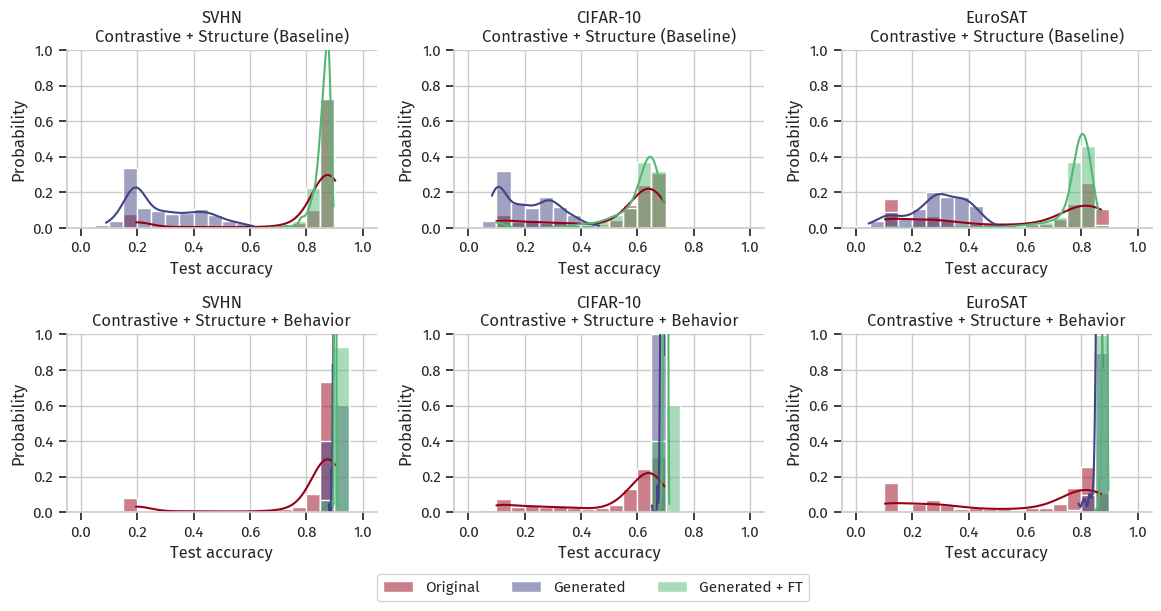

In [36]:
_, axs = plt.subplots(2, 3, figsize=(14, 6))

for d, ds in enumerate(DATASETS):
    ds_label = DATASET_LABELS[ds]
    df_zoo_acc = zoo_acc[zoo_acc['Model zoo'] == ds_label]
    df_generative_ds = df_generative[df_generative['Model zoo'] == ds_label]

    label = 'Contrastive + Structure (Baseline)'
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[0][d])
    #sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstructed', ax=axs[0][d])
    sns.histplot(
        df_generative_ds[(df_generative_ds['Hyper-representation model'] == label) & (df_generative_ds['Generation'] == 'Generated')],
        x='Accuracy',
        stat='probability',
        binwidth=0.05,
        binrange=(0., 1.),
        kde=True,
        color=COLOURS[2],
        alpha=0.5,
        label='Generated',
        ax=axs[0][d]
    )
    sns.histplot(
        df_generative_ds[(df_generative_ds['Hyper-representation model'] == label) & (df_generative_ds['Generation'] == 'Generated + FT')],
        x='Accuracy',
        stat='probability',
        binwidth=0.05,
        binrange=(0., 1.),
        kde=True,
        color=COLOURS[3],
        alpha=0.5,
        label='Generated + FT',
        ax=axs[0][d]
    )
    axs[0][d].set(title=f"{ds_label}\n{label}", xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    
    label = 'Contrastive + Structure + Behavior'
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[1][d])
    #sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstructed', ax=axs[1][d])
    sns.histplot(
        df_generative_ds[(df_generative_ds['Hyper-representation model'] == label) & (df_generative_ds['Generation'] == 'Generated')],
        x='Accuracy',
        stat='probability',
        binwidth=0.05,
        binrange=(0., 1.),
        kde=True,
        color=COLOURS[2],
        alpha=0.5,
        label='Generated',
        ax=axs[1][d]
    )
    sns.histplot(
        df_generative_ds[(df_generative_ds['Hyper-representation model'] == label) & (df_generative_ds['Generation'] == 'Generated + FT')],
        x='Accuracy',
        stat='probability',
        binwidth=0.05,
        binrange=(0., 1.),
        kde=True,
        color=COLOURS[3],
        alpha=0.5,
        label='Generated + FT',
        ax=axs[1][d]
    )
    axs[1][d].set(title=f"{ds_label}\n{label}", xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    
plt.legend(loc=(-1.50, -0.50), ncols=3)
plt.subplots_adjust(hspace=0.6, wspace=0.25)
plt.savefig('figures/generative_dstk.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
max_acc = zoo_acc.groupby(['Model zoo', 'Hyper-representation model'])[['Original accuracy', 'Reconstruction accuracy']].max()

# Adding max performance data for the entire zoo
max_acc['Zoo accuracy'] = max_acc.index.get_level_values('Model zoo').map(df_zoo.groupby(['Model zoo'])['Test accuracy'].max().to_dict())

# This data corresponds to the test split of the model zoo only
max_acc['Test split accuracy'] = max_acc['Original accuracy']
max_acc = max_acc.drop('Original accuracy', axis=1)

# Adding max performance data for generated models
max_acc['Generation accuracy'] = df_generative[df_generative['Generation'] == 'Generated'].groupby(['Model zoo', 'Hyper-representation model'])['Accuracy'].max()
max_acc['Generation + FT accuracy'] = df_generative[df_generative['Generation'] == 'Generated + FT'].groupby(['Model zoo', 'Hyper-representation model'])['Accuracy'].max()

# Computing max performance difference between reconstructed / generated models and the entire zoo
max_acc['$\Delta_{Acc}$ Reconstruction'] = max_acc['Reconstruction accuracy'] - max_acc['Zoo accuracy']
max_acc['$\Delta_{Acc}$ Generation'] = max_acc['Generation accuracy'] - max_acc['Zoo accuracy']
max_acc['$\Delta_{Acc}$ Generation + FT'] = max_acc['Generation + FT accuracy'] - max_acc['Zoo accuracy']

# Re-ordering lines
new_index = pd.MultiIndex.from_product([DS_ORDER, ['Contrastive + Structure (Baseline)', 'Contrastive + Structure + Behavior']], names=['Model zoo', 'Hyper-representation model'])
max_acc = max_acc.reindex(new_index).loc[:, ['Zoo accuracy', 'Reconstruction accuracy', '$\Delta_{Acc}$ Reconstruction', 'Generation accuracy', '$\Delta_{Acc}$ Generation', 'Generation + FT accuracy', '$\Delta_{Acc}$ Generation + FT']]

# Print
max_acc = max_acc.style.format('{:.1%}')
print(max_acc.to_latex())
max_acc

\begin{tabular}{llrrrrrrr}
 &  & Zoo accuracy & Reconstruction accuracy & $\Delta_{Acc}$ Reconstruction & Generation accuracy & $\Delta_{Acc}$ Generation & Generation + FT accuracy & $\Delta_{Acc}$ Generation + FT \\
Model zoo & Hyper-representation model &  &  &  &  &  &  &  \\
\multirow[c]{2}{*}{SVHN} & Contrastive + Structure (Baseline) & 91.0% & 74.5% & -16.5% & 61.6% & -29.5% & 89.7% & -1.3% \\
 & Contrastive + Structure + Behavior & 91.0% & 90.4% & -0.6% & 90.4% & -0.6% & 90.9% & -0.1% \\
\multirow[c]{2}{*}{CIFAR-10} & Contrastive + Structure (Baseline) & 70.1% & 51.2% & -18.9% & 46.5% & -23.6% & 69.5% & -0.6% \\
 & Contrastive + Structure + Behavior & 70.1% & 69.5% & -0.6% & 69.5% & -0.6% & 71.4% & 1.3% \\
\multirow[c]{2}{*}{EuroSAT} & Contrastive + Structure (Baseline) & 88.5% & 68.6% & -19.9% & 56.5% & -32.0% & 86.6% & -1.9% \\
 & Contrastive + Structure + Behavior & 88.5% & 87.7% & -0.8% & 87.5% & -1.0% & 89.7% & 1.2% \\
\end{tabular}

